# Using `memento` to analyze Interferon-B response in monocytes

Data found in https://memento-examples.s3.us-west-2.amazonaws.com/pbmc-ifnb/interferon_filtered.h5ad. 

In [1]:
import memento
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import scanpy as sc
import memento

In [3]:
data_path = '/home/ubuntu/Data/tutorial_data/pbmc-ifnb/'

### Read IFN data and filter for monocytes

For `memento`, we need the raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at. `adata.X` should be a sparse matrix containing positive integers.

One of the columns in `adata.obs` should be the discrete groups to compare mean, variability, and co-variability across. In this case, it's called `stim`. 

The column containing the covariate that you want p-values for should either:
- Be binary (aka the column only contains two unique values, such as 'A' and 'B'. Here, the values are either 'stim' or 'ctrl'.
- Be numeric (aka the column contains -1, 0, -1 for each genotype value). 

I recommend changing the labels to something numeric (here, i use 0 for `ctrl` and 1 for `stim`). Otherwise, the sign of the DE/EV/DC testing will be very hard to interpret.

In [4]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
print(adata)

AnnData object with n_obs × n_vars = 5341 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_type'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


In [5]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 0 if x == 'ctrl' else 1)

In [6]:
adata.obs[['ind', 'stim', 'cell']].sample(5)

,ind,stim,cell
index,,,
GCCTCAACCTGAAC-1,1256,1,CD14+ Monocytes
GCAGCGTGAACGGG-1,101,1,CD14+ Monocytes
CGGACTCTTGCATG-1,1244,0,CD14+ Monocytes
TAATCGCTCGGGAA-1,1016,0,CD14+ Monocytes
GTGTACGATTGGCA-1,1015,0,CD14+ Monocytes


### Perform the binary comparison between two groups

`capture_rate` is the rough estimate of the overall UMI efficiency across both sampling and sequencing. If `s` is the sequencing saturation, multiply `s` by 0.07 for 10X v1, 0.15 for v2, and 0.25 for v3. This allows you to enter different numbers for each batch, which likely have different saturation numbers. This will NOT account for wildly different sequencing scenarios. Here, we used 10X v1 chemistry along with sequencing to saturation (100%). 

`treatment_col` is the column in `adata.obs` DataFrame that defines the treatment variable, aka the independent variable for this test. In our case, this column indicates whether the cell got IFN-B stimulation or not.

`num_cpus` controls how many CPUs to parallelize this operation for. In general, I recommend using 3-6 CPUs for reasonable peformance on any of the AWS machines that we have access to (I'm currently using a c5.2xlarge instance (8 vCPUs). 

`num_boot` controls how many bootstrap iterations to perform.

In [7]:
result_1d = memento.binary_test_1d(
    adata=adata, 
    capture_rate=0.07, 
    treatment_col='stim', 
    num_cpus=12,
    num_boot=5000)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 244 tasks      | elapsed:    4.2s
[Parallel(n_jobs=12)]: Done 744 tasks      | elapsed:   10.2s
[Parallel(n_jobs=12)]: Done 1444 tasks      | elapsed:   20.5s
[Parallel(n_jobs=12)]: Done 1854 out of 1877 | elapsed:   26.4s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 1877 out of 1877 | elapsed:   27.2s finished


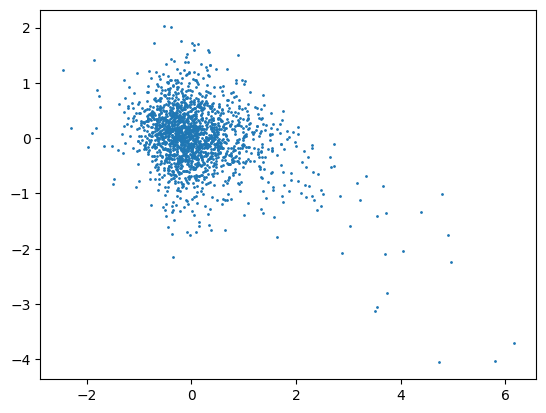

In [8]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)

### Print the top differential mean genes (DM) and top differential variability genes (DV)

`de_coef` and `de_pval` refer to the mean effect size and uncorrected differential mean p-value respectively.

`ve_coef` and `dv_pval` refer to the variability effect size and uncorrected differential variability p-value respectively.

In [9]:
result_1d.query('de_coef > 0').sort_values('de_pval').head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,ISG15,stim,4.735176,0.080462,0.0,-4.057520,0.385885,3.703513e-26
1869,MX1,stim,3.718690,0.077490,0.0,-1.348751,0.147682,3.773009e-20
98,GBP1,stim,2.169482,0.046397,0.0,-0.840221,0.127051,4.009790e-11
1851,TYMP,stim,1.041270,0.016814,0.0,-0.161540,0.077796,3.947181e-02
1575,H3F3B,stim,0.654287,0.012470,0.0,-0.268918,0.071636,1.901070e-04
1545,IFI35,stim,2.472627,0.055519,0.0,-1.229297,0.170385,3.077914e-13
1787,IL4I1,stim,2.005472,0.046894,0.0,-0.136503,0.123821,2.466097e-01
1729,BST2,stim,1.737571,0.031173,0.0,-1.054215,0.142110,8.408791e-14
1411,PSMA4,stim,1.287618,0.031213,0.0,0.038375,0.175158,8.212502e-01
1421,ISG20,stim,3.729167,0.054182,0.0,-2.799271,0.135871,1.316147e-94


In [10]:
result_1d.query('dv_coef > 0 & de_coef > 0').sort_values('dv_pval').head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
1828,LGALS1,stim,0.019160,0.017979,2.930306e-01,0.328217,0.063371,1.870296e-07
1309,FAM177A1,stim,0.893239,0.046439,2.698617e-82,1.510164,0.292475,4.533945e-07
1827,LGALS2,stim,1.374469,0.077577,5.934896e-70,0.783232,0.161597,1.315410e-06
1537,CCR7,stim,1.030471,0.136539,4.222260e-14,1.034259,0.238576,1.031248e-05
114,RHOC,stim,0.346680,0.076247,5.623478e-06,1.323172,0.315185,1.646052e-05
1392,RPS27L,stim,0.402844,0.047847,5.006384e-17,0.637207,0.163193,1.426129e-04
1258,SAP18,stim,0.794452,0.030303,1.347225e-151,0.827740,0.225352,3.069839e-04
396,PCNP,stim,0.121183,0.068410,7.621075e-02,1.695628,0.583370,2.314833e-03
1346,CALM1,stim,1.329693,0.036177,1.280737e-295,0.352380,0.116348,2.585409e-03
1768,CALM3,stim,0.124146,0.042844,3.413735e-03,0.706682,0.247304,2.918654e-03


### Perform 2D hypothesis testing

For differential coexpression testing, we can specify which genes you want to perform HT on. It takes a list of pairs of genes, where each element in the list is a tuple. Here, we focus on 1 transcription factor and their correlations to rest of the transcriptome. The `binary_test_2d` function will automatically filter out genes that do not meet the criteria for testing.

Similar to the 1D case, 2D hypothesis testing scales with the number of pairs of genes to test. If you have a smaller set of candidate genes, it will run faster.

`corr_coef` and `corr_pval` refer to the coexpression effect size and uncorrected differential coexpression p-value respectively.


In [11]:
import itertools

In [12]:
gene_pairs = list(itertools.product(['IRF7'], adata.var.index.tolist()))

In [13]:
result_2d = memento.binary_test_2d(
    adata=adata, 
    gene_pairs=gene_pairs, 
    capture_rate=0.07, 
    treatment_col='stim', 
    num_cpus=12, 
    num_boot=5000)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   14.4s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   37.6s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 1876 out of 1876 | elapsed:  2.2min finished


In [14]:
result_2d.sort_values('corr_pval').head(5)

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval
574,IRF7,CD74,stim,0.353853,0.047130,6.031143e-14
638,IRF7,HLA-DRA,stim,0.270864,0.045392,2.413151e-09
1814,IRF7,UBE2L3,stim,0.339630,0.057499,3.796863e-09
716,IRF7,ACTB,stim,0.301090,0.051304,5.346681e-09
641,IRF7,HLA-DQA1,stim,0.320557,0.055073,5.919338e-09
